# Predicting Insurance Risk using Machine Learning (ML)

## Background
Historically, the business has used traditional risk quantification methods in order to predict the risk of offering an insurance policy to a potential customer. The risk is the probability of a customer filing a claim within one year of policy purchase, resulting in a loss for the business.

## The challenge
Traditional methods have been used for a long time, and stakeholders are not yet confident in the ability of ML methodology. We need to demonstrate how and why adopting ML can provide additional value in an easy to understand manner.

## Objective
This project aims to:
- Synthesise a dataset of 10,000 customers that is akin to a real-world insurance company dataset.
- Provide Exploratory Data Analysis (EDA) and context behind pre-processing of the data.
- Develop an ML model proof of concept that will predict the risk profile of each customer, to determine product price.
- Explain how the model could be used to ensure only 5% of people that buy a policy would claim on their policy.
- Provide next steps to cover what steps need to be taken to take the proof of concept into production.

## Impact
This notebook aims to provide evidence of the potential of ML methodology to add value to the business, improving accuracy compared with traditional risk quantification methods. Transparency of the work behind the proof of concept aims to aid stakeholder understanding, increasing knowledge and encouraging the organisation to embrace ML technology.

## Data Synthesis

QUESTION To demonstrate the machine learning service, we need you to synthesise some data that resembles the real-world data that an insurance company would have. You will need to generate a dataset of 10000 customers, each with 40 features that describe their personal and financial characteristics. Some of the features could be numerical, such as age, income, credit score, and number of dependents. Some of the features could be categorical, such as gender, marital status, education level, and occupation. Some of the features will be ordinal, such as health status, driving record, and home ownership.  Finally, we would expect to have some missing values and duplicates, if these were real world data.  You can either synthesise this in, and it handle later, or discuss how you would have treated the data if it were there.
The target variable is the binary claim status of 0 or 1.

In [163]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define size of dataset and set random seed for reproducibility
n = 10000
np.random.seed(42)

# Define numerical features
age = np.random.randint(18, 90, n)  # random number in range
income = np.random.lognormal(mean=10, sigma=1, size=n)  # skewed distribution / exp(mean + (sigma*2 /2))
credit_score = np.random.normal(loc=680, scale=50, size=n)  # normal distribution, loc=mean, scale=standard deviation
dependents = np.random.poisson(lam=1.5, size=n)  # event count, lam=mean rate
annual_premium = np.random.normal(loc=750, scale=150, size=n)
vehicle_age = np.random.randint(0, 20, n)
claim_amount_last_year = np.random.exponential(scale=300, size=n)  # rare high values, clustered low
total_claims_past_5_years = np.random.poisson(1.2, n)
time_employed = np.random.randint(0, 15, n)
distance_to_work = np.random.normal(10, 5, n)
vehicle_value = np.random.normal(15000, 5000, n)
years_with_license = np.random.randint(1, 70, n)
coverage_limit = np.random.normal(loc=30000, scale=15000, size=n)

# Define categorical features
gender = np.random.choice(['male', 'female', 'other'], n) # random selection from list
marital_status = np.random.choice(['single', 'married', 'divorced'], n)
education = np.random.choice(['high School', 'college', 'bachelor’s', 'master’s', 'phd'], n)
occupation = np.random.choice(['teacher', 'engineer', 'nurse', 'artist', 'data scientist'], n)
vehicle_type = np.random.choice(['saloon', 'hatch-back', 'suv', 'motorcycle', 'van'], n)
policy_type = np.random.choice(['third_party', 'comprehensive'], n)
employment_type = np.random.choice(['full_time', 'part-time', 'self-employed', 'unemployed', 'retired'], n)
previous_insurer = np.random.choice(['a', 'b', 'c'], n)
accident_history = np.random.choice(['none', 'minor', 'major'], n)
has_previous_claims = np.random.choice([0, 1], n)

# Define ordinal features
health_status = np.random.randint(1, 6, n)
driving_record = np.random.choice(['poor', 'fair', 'good', 'excellent'], n)
home_ownership = np.random.choice(['renting', 'owned', 'mortgaged'], n)
customer_loyalty_rating = np.random.randint(1, 6, n)
region = np.random.choice(["scotland", "northern ireland", "ireland", "england", "wales"])
vehicle_condition = np.random.choice(['poor', 'fair', 'good', 'excellent'], n)
payment_timeliness = np.random.choice(['always', 'mostly', 'occasionally', 'never'], n)
claim_satisfaction_rating = np.random.randint(1, 6, n)
policy_category = np.random.choice(['new', 'short_term', 'long_term'], n, p=[0.2, 0.4, 0.4])

# Boolean features
has_anti_theft_device = np.random.choice([0, 1], n)
owns_garage = np.random.choice([0, 1], n)
has_additional_drivers = np.random.choice([0, 1], n)
is_smoker = np.random.choice([0, 1], n)
has_medical_conditions = np.random.choice([0, 1], n)
uses_vehicle_for_commute = np.random.choice([0, 1], n)
uses_vehicle_for_business = np.random.choice([0, 1], n)
modifications_to_vehicle = np.random.choice([0, 1], n, p=[0.85, 0.15])
predicted_claim = np.random.choice([0, 1], n)

# Convert driving record to risk score
# driving_risk = np.array([1 if dr == 'poor' else 0 for dr in driving_record])

# # Build simplified risk score
# predicted_risk = (
#     (income < 40000).astype(int) +         # Low income increases risk
#     driving_risk +                         # Poor driving increases risk
#     has_previous_claims +                  # History of claims increases risk
#     (vehicle_age > 15).astype(int)         # Older vehicle increases risk
# )

# # Convert to binary target: label as '1' if risk factors ≥ 2
# predicted_claim = (predicted_risk >= 2).astype(int)

# Round values

# Combine into DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'dependents': dependents,
    'annual_premium': annual_premium,
    'vehicle_age': vehicle_age,
    'claim_amount_last_year': claim_amount_last_year,
    'total_claims_past_5_years': total_claims_past_5_years,
    'time_employed': time_employed,
    'distance_to_work': distance_to_work,
    'vehicle_value': vehicle_value,
    'years_with_license': years_with_license,
    'coverage_limit': coverage_limit,

    'gender': gender,
    'marital_status': marital_status,
    'education': education,
    'occupation': occupation,
    'vehicle_type': vehicle_type,
    'policy_type': policy_type,
    'employment_type': employment_type,
    'previous_insurer': previous_insurer,
    'accident_history': accident_history,
    'has_previous_claims': has_previous_claims,

    'health_status': health_status,
    'driving_record': driving_record,
    'home_ownership': home_ownership,
    'customer_loyalty_rating': customer_loyalty_rating,
    'region': region,
    'vehicle_condition': vehicle_condition,
    'payment_timeliness': payment_timeliness,
    'claim_satisfaction_rating': claim_satisfaction_rating,
    'policy_category': policy_category,

    'has_anti_theft_device': has_anti_theft_device,
    'owns_garage': owns_garage,
    'has_additional_drivers': has_additional_drivers,
    'is_smoker': is_smoker,
    'has_medical_conditions': has_medical_conditions,
    'uses_vehicle_for_commute': uses_vehicle_for_commute,
    'uses_vehicle_for_business': uses_vehicle_for_business,
    'modifications_to_vehicle': modifications_to_vehicle,

    'predicted_claim': predicted_claim
})

# Round values as needed
df['income'] = df['income'].round(2)
df['credit_score'] = df['credit_score'].round().astype(int)
df['annual_premium'] = df['annual_premium'].round().astype(int)
df['claim_amount_last_year'] = df['claim_amount_last_year'].round(0)
df['distance_to_work'] = df['distance_to_work'].round(1)
df['vehicle_value'] = df['vehicle_value'].round(-2)  # nearest hundred
df['coverage_limit'] = df['coverage_limit'].round(-3) 

# Introduce some missing values to replicate real data
for col in df.columns:
    df.loc[df.sample(frac=0.05).index, col] = np.nan

# Add 1% duplicates to replicate real data
dupes = df.sample(frac=0.01)
df = pd.concat([df, dupes], ignore_index=True)

Visualise the first five rows of the table as a sense check

In [164]:
print(df.shape[1])
pd.set_option('display.max_columns', 50)
df.head()

41


,age,income,credit_score,dependents,annual_premium,vehicle_age,claim_amount_last_year,total_claims_past_5_years,time_employed,distance_to_work,vehicle_value,years_with_license,coverage_limit,gender,marital_status,education,occupation,vehicle_type,policy_type,employment_type,previous_insurer,accident_history,has_previous_claims,health_status,driving_record,home_ownership,customer_loyalty_rating,region,vehicle_condition,payment_timeliness,claim_satisfaction_rating,policy_category,has_anti_theft_device,owns_garage,has_additional_drivers,is_smoker,has_medical_conditions,uses_vehicle_for_commute,uses_vehicle_for_business,modifications_to_vehicle,predicted_claim
0,69.0,14103.95,608.0,4.0,581.0,15.0,49.0,2.0,5.0,14.5,9500.0,13.0,59000.0,other,divorced,phd,engineer,saloon,comprehensive,unemployed,c,minor,NaN,5.0,poor,renting,1.0,england,fair,always,1.0,short_term,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,32.0,36160.60,691.0,1.0,503.0,19.0,1932.0,0.0,11.0,15.5,NaN,43.0,24000.0,NaN,divorced,high School,engineer,van,comprehensive,unemployed,b,NaN,0.0,5.0,excellent,owned,5.0,england,good,never,4.0,short_term,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2,89.0,142734.96,743.0,NaN,668.0,10.0,743.0,0.0,12.0,14.4,15200.0,53.0,NaN,other,married,high School,nurse,suv,comprehensive,retired,c,major,0.0,1.0,good,mortgaged,3.0,england,fair,never,4.0,long_term,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,78.0,13806.12,757.0,1.0,838.0,17.0,696.0,0.0,7.0,15.5,13500.0,22.0,0.0,other,single,phd,teacher,hatch-back,third_party,full_time,a,major,1.0,2.0,poor,owned,1.0,england,fair,never,3.0,new,0.0,1.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0
4,38.0,87570.37,696.0,2.0,685.0,16.0,1.0,2.0,10.0,14.9,9900.0,36.0,39000.0,other,married,phd,NaN,van,third_party,unemployed,c,minor,1.0,2.0,poor,mortgaged,3.0,england,poor,occasionally,2.0,long_term,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


## Data Exploration and Preprocessing

QUESTION We want to understand your process for tackling the task, i.e. how the data is explored and manipulated is how we understand your process.  What assumptions are you making and why are you using the approach you have gone with?

In [165]:
# Print number of rows and data types
print(f"\nNumber of columns before preprocessing:", df.shape[1])
print(f"Number of rows before preprocessing:", len(df))

# Check for duplicates and remove them
duplicates = df.duplicated()
print(f"\nNumber of duplicates found: {duplicates.sum()}")
df[duplicates].head()

before = df.shape[0]
df = df.drop_duplicates(keep='last')
after = df.shape[0]

print(f"Number of duplicates removed: {before - after}")

# Remove rows with blank label values, do not use imputation
df = df.dropna(subset=['predicted_claim'])

# Account for NaN values - imputation or drop column
# Use mean for continuous data normal distribution
# Use median for continous data non-normal distribution
# Use mode for categorical data

# Threshold for dropping columns
missing_thresh = 0.3
missing_percent = df.isna().mean()

# Drop columns with > 40% missing
df = df.drop(columns=missing_percent[missing_percent > missing_thresh].index)

# Initialize counters
mean_imputations = {}
median_imputations = {}
mode_imputations = {}

# Initialize counters
mean_total = 0
median_total = 0
mode_total = 0

for col in df.columns:
    missing_count = df[col].isna().sum()
    if missing_count == 0:
        continue

    if df[col].dtype in [np.float64, np.int64]:
        skew = df[col].skew()
        if abs(skew) < 0.5:
            impute_val = df[col].mean()
            df[col] = df[col].fillna(impute_val)
            mean_total += missing_count
        else:
            impute_val = df[col].median()
            df[col] = df[col].fillna(impute_val)
            median_total += missing_count
    else:
        impute_val = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(impute_val)
        mode_total += missing_count

# Final report
print("\nImputed value counts:")
print(f"Mean imputations: {mean_total}")
print(f"Median imputations: {median_total}")
print(f"Mode imputations: {mode_total}")

# Print number of rows and data types
print(f"\nNumber of columns after preprocessing:", df.shape[1])
print(f"Number of rows after preprocessing:", len(df))



Number of columns before preprocessing: 41
Number of rows before preprocessing: 10100

Number of duplicates found: 100
Number of duplicates removed: 100

Imputed value counts:
Mean imputations: 9505
Median imputations: 2377
Mode imputations: 7115

Number of columns after preprocessing: 41
Number of rows after preprocessing: 9500


✔️ Cleaned columns: ['has_anti_theft_device', 'owns_garage', 'has_additional_drivers', 'is_smoker', 'has_medical_conditions', 'uses_vehicle_for_commute', 'uses_vehicle_for_business', 'has_previous_claims']


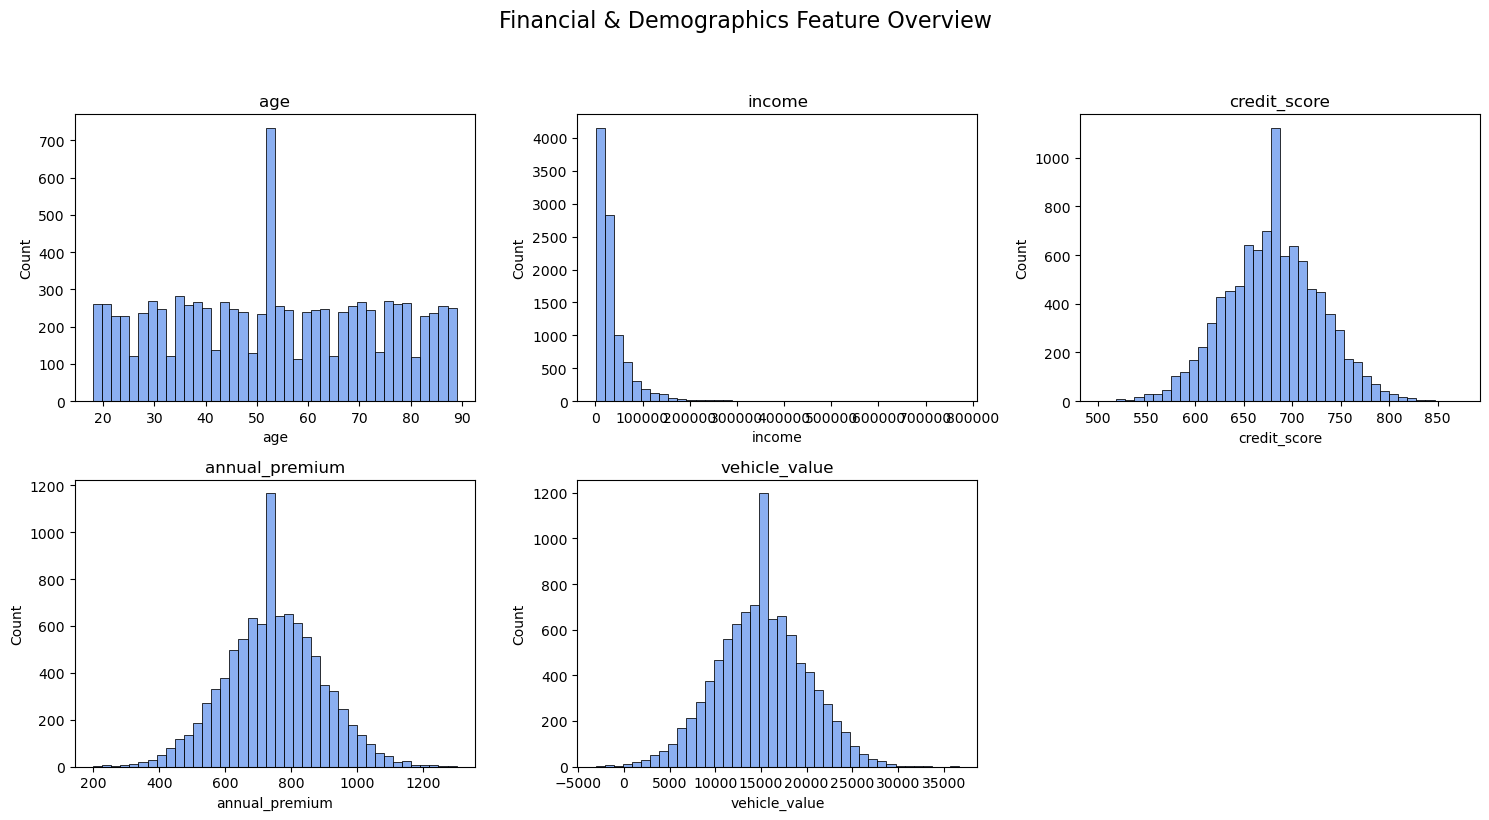

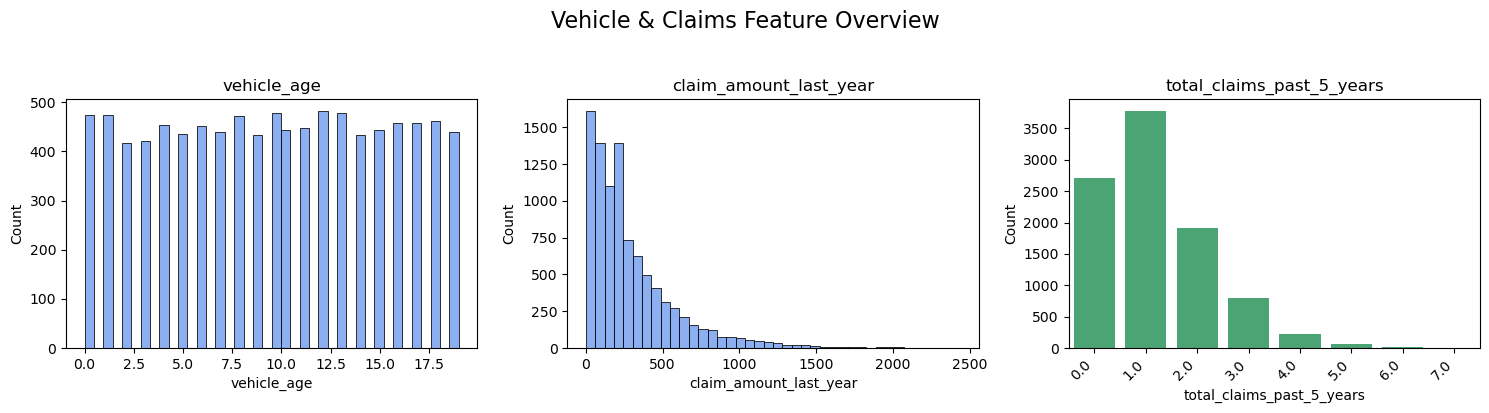

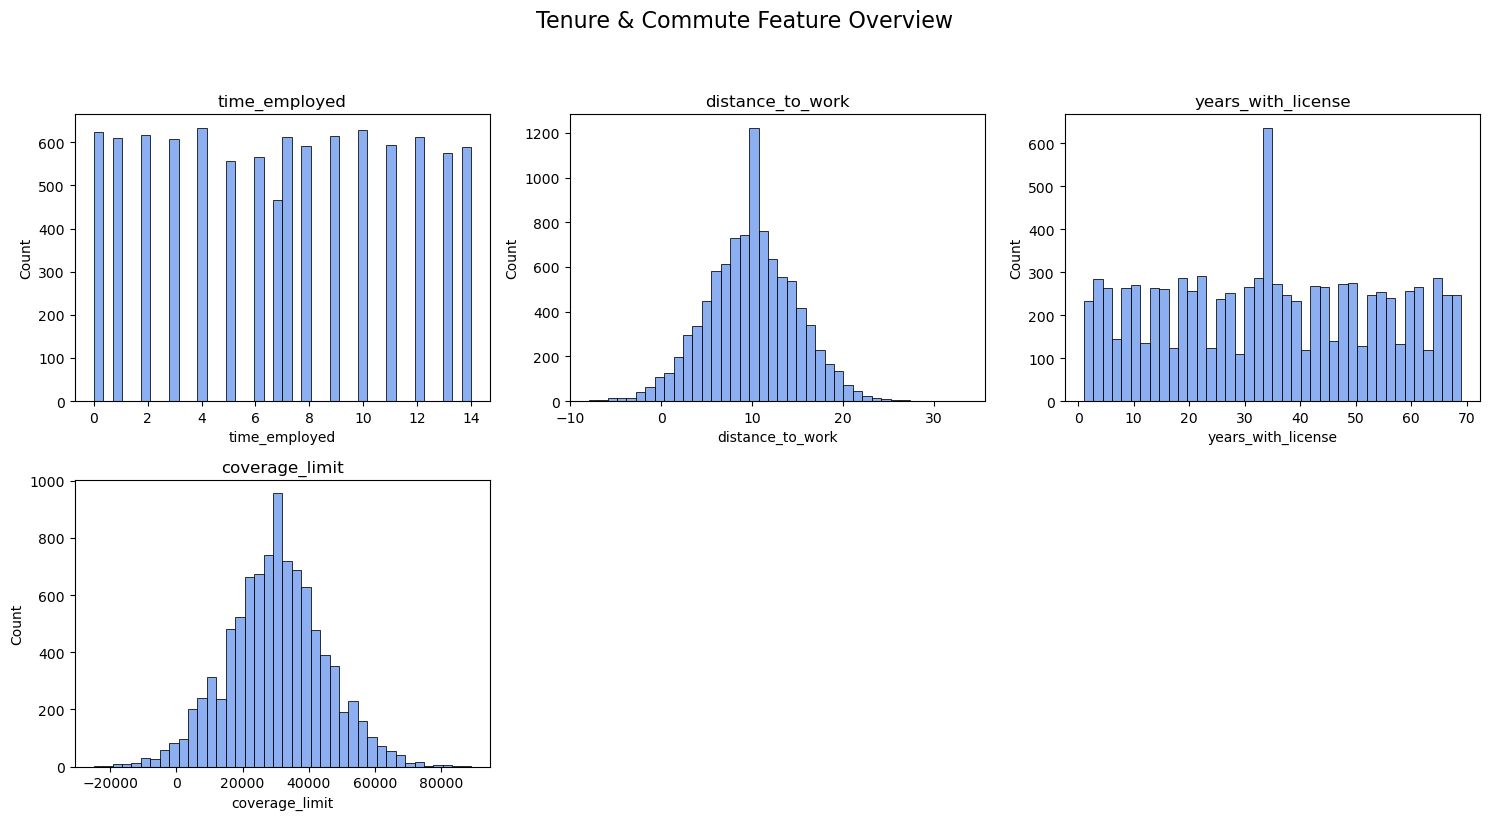

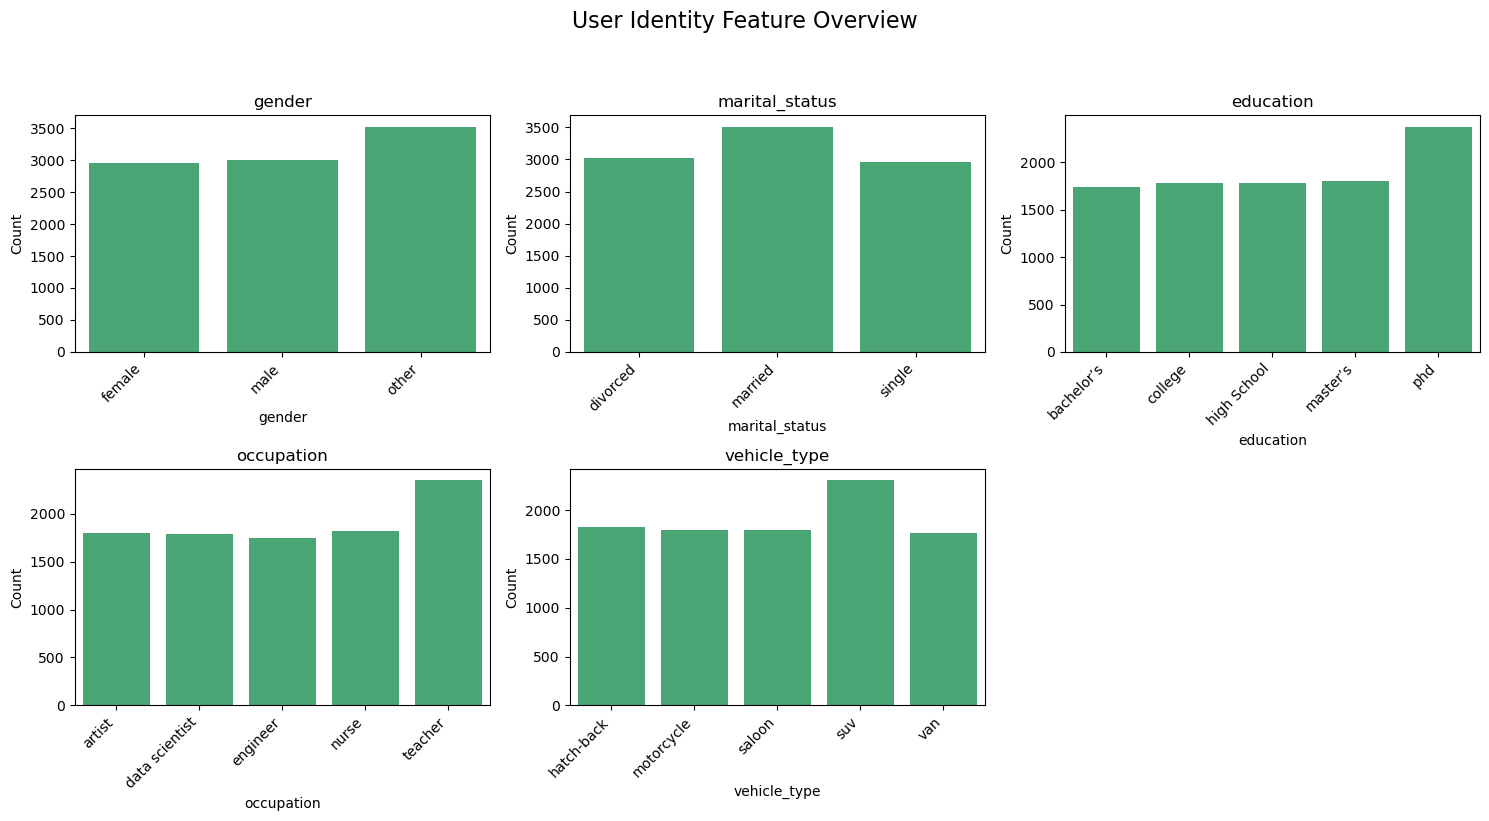

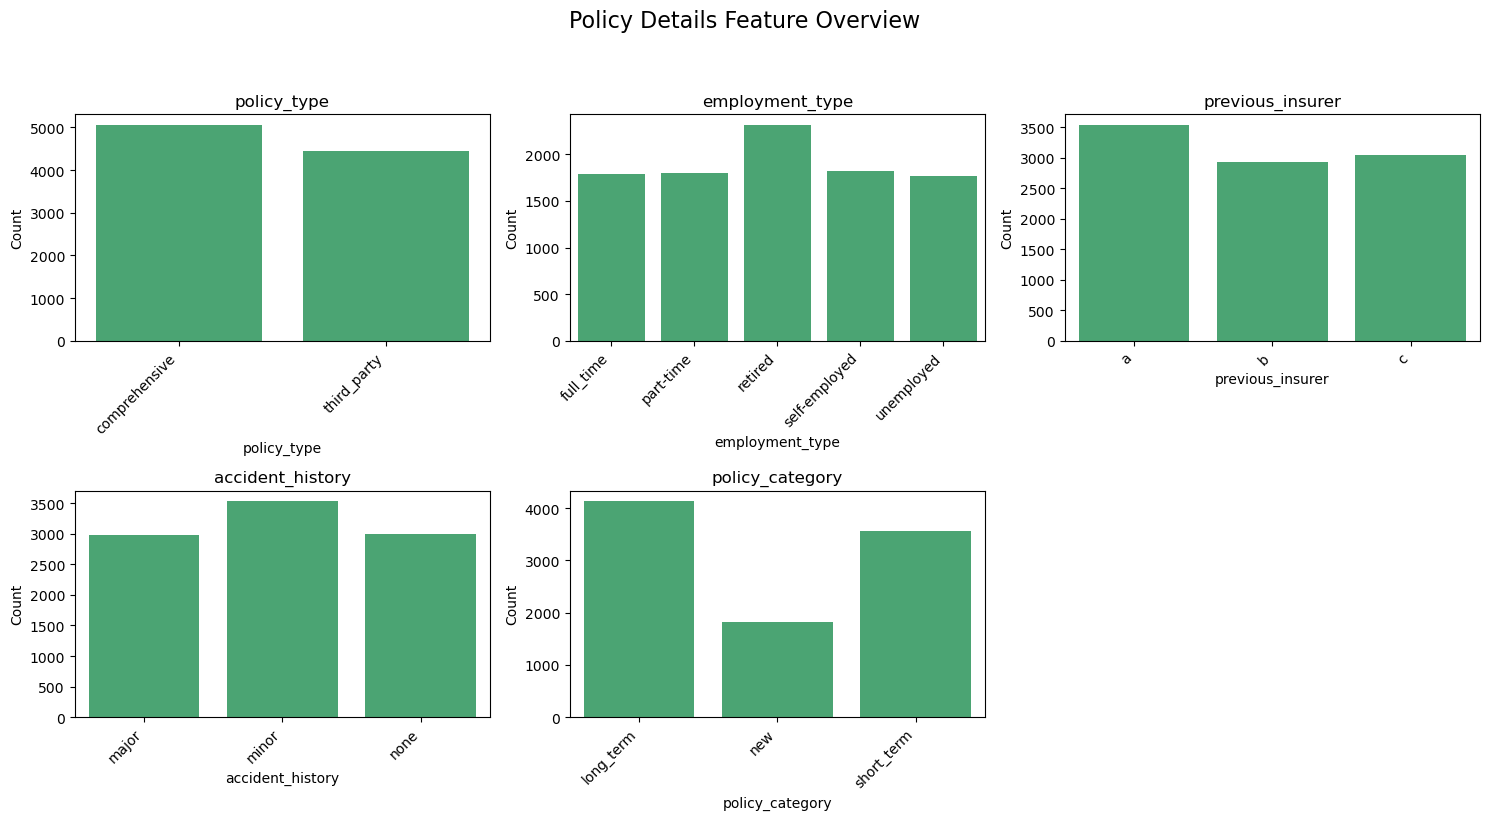

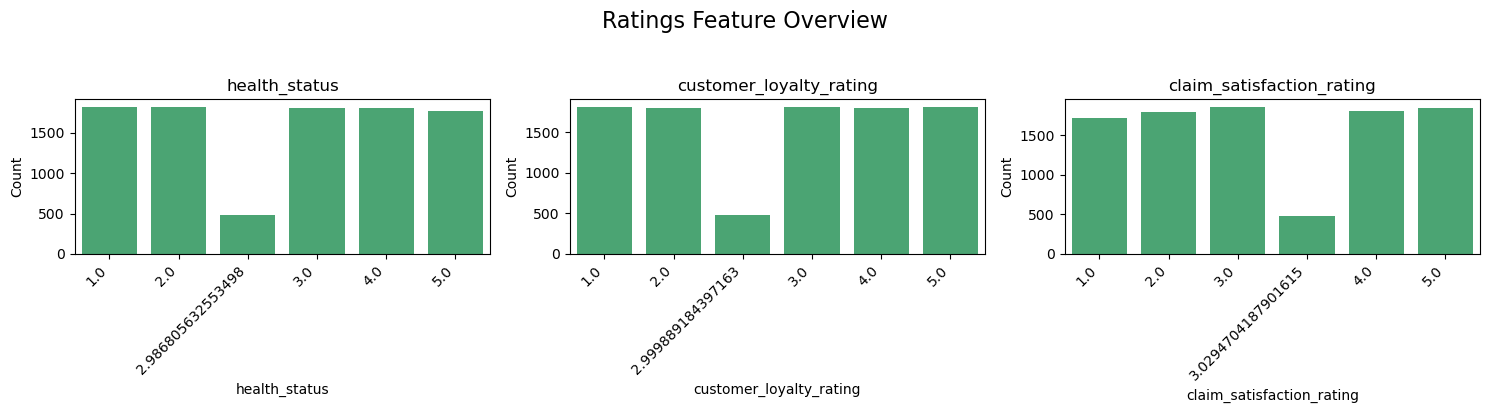

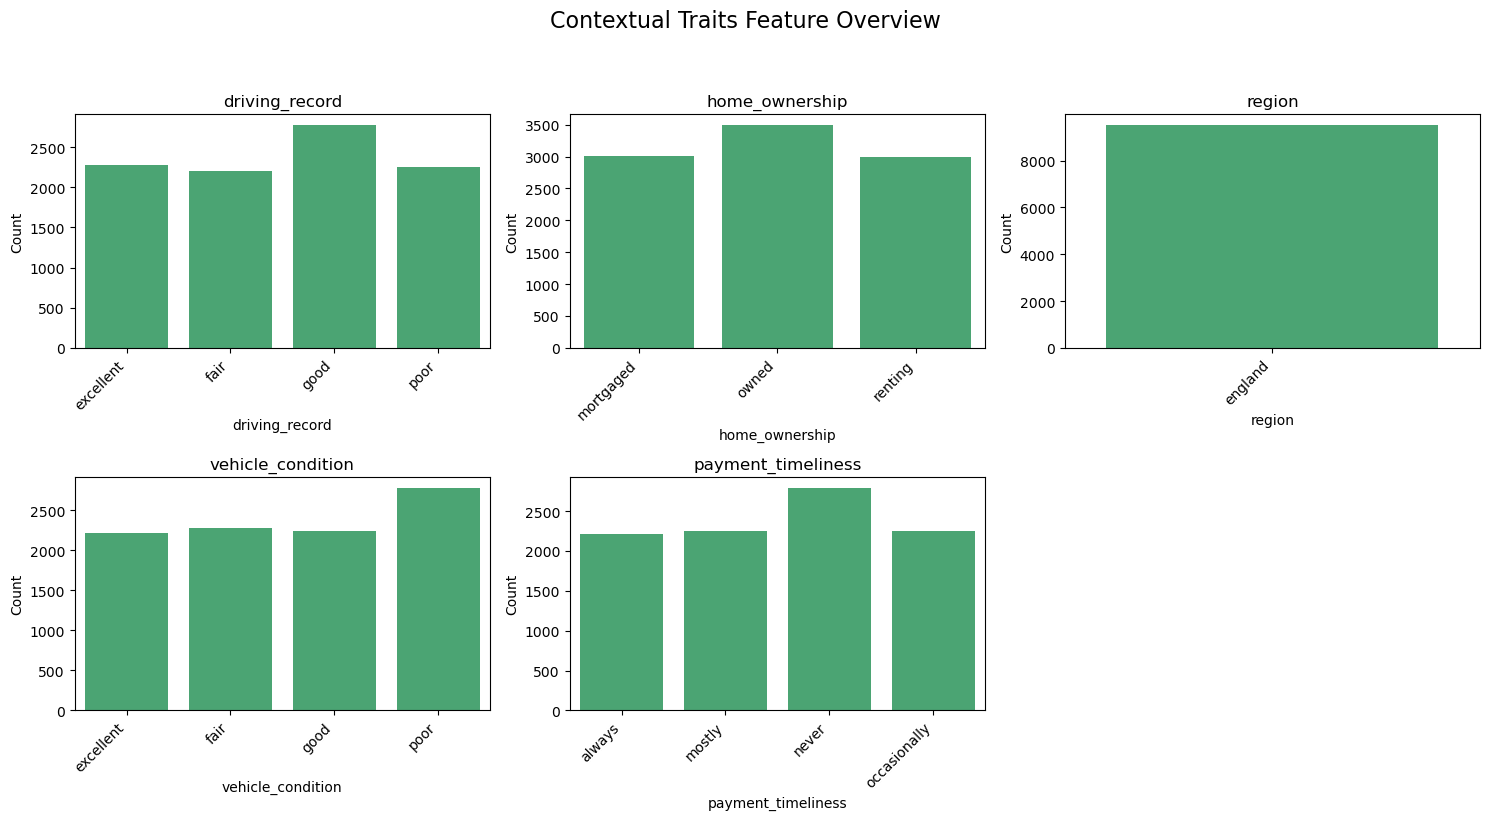

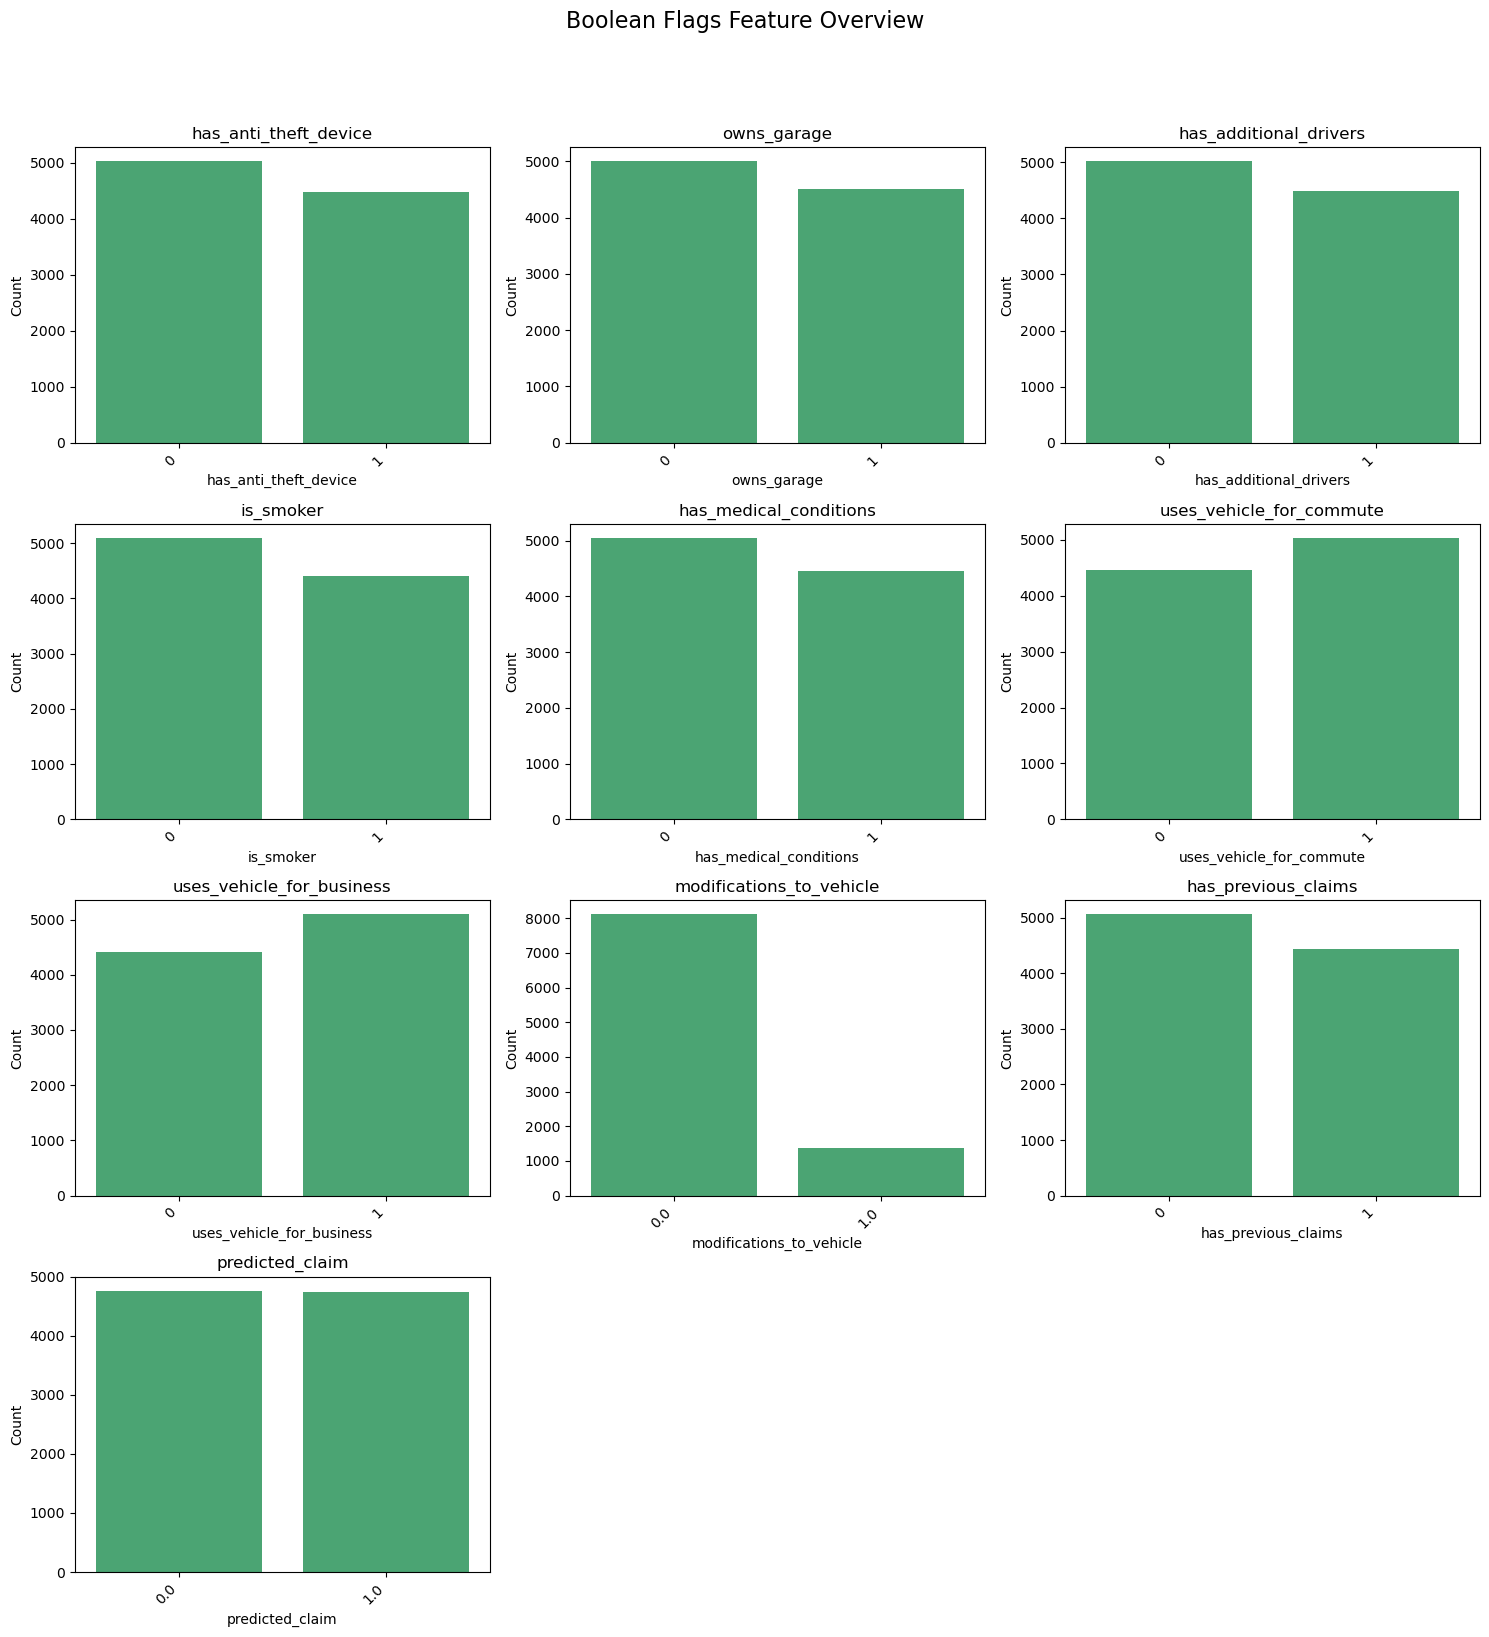

In [ ]:
# Feature groups for visualisation
group1_numeric = ['age', 'income', 'credit_score', 'annual_premium', 'vehicle_value']  # Financial/Demographics
group2_numeric = ['vehicle_age', 'claim_amount_last_year', 'total_claims_past_5_years']  # Vehicle/Claims
group3_numeric = ['time_employed', 'distance_to_work', 'years_with_license', 'coverage_limit']  # Tenure/Commute
group4_categorical = ['gender', 'marital_status', 'education', 'occupation', 'vehicle_type']  # Identity
group5_categorical = ['policy_type', 'employment_type', 'previous_insurer', 'accident_history', 'policy_category']  # Policy/Usage
group6_ordinal = ['health_status', 'customer_loyalty_rating', 'claim_satisfaction_rating']  # Ratings
group7_categorical = ['driving_record', 'home_ownership', 'region', 'vehicle_condition', 'payment_timeliness']  # Context
group8_boolean = ['has_anti_theft_device', 'owns_garage', 'has_additional_drivers', 'is_smoker',
                  'has_medical_conditions', 'uses_vehicle_for_commute', 'uses_vehicle_for_business',
                  'modifications_to_vehicle', 'has_previous_claims', 'predicted_claim']

def fix_boolean_columns(df, bool_cols, threshold=0.5):
    fixed_cols = []
    
    for col in bool_cols:
        unique_vals = df[col].dropna().unique()
        is_binary = np.array_equal(np.sort(unique_vals), [0, 1])
        
        if not is_binary:
            # Convert to 0 or 1 based on threshold
            df[col] = (df[col] > threshold).astype(int)
            fixed_cols.append(col)
    
    print(f"Cleaned columns: {fixed_cols}" if fixed_cols else "All columns were already binary.")
    return df

df = fix_boolean_columns(df, group8_boolean)

def smart_subplots(df, features, group_name, cols=3, cardinality_threshold=10):
    rows = (len(features) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Easy iteration even if fewer plots than slots
    plt.suptitle(f"{group_name} Feature Overview", fontsize=16, y=1.02)

    for i, feat in enumerate(features):
        ax = axes[i]
        is_numeric = df[feat].dtype in [np.int64, np.float64]
        unique_vals = df[feat].nunique()

        if is_numeric and unique_vals > cardinality_threshold:
            sns.histplot(df[feat], bins=40, ax=ax, color='cornflowerblue')
        else:
            vc = df[feat].value_counts().sort_index()
            sns.barplot(x=vc.index, y=vc.values, ax=ax, color='mediumseagreen')
            ax.set_xticks(np.arange(len(vc.index))) 
            ax.set_xticklabels(vc.index, rotation=45, ha='right')

        ax.set_title(feat)
        ax.set_xlabel(feat)
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Numeric groups (histograms)
smart_subplots(df, group1_numeric, 'Financial & Demographics')
smart_subplots(df, group2_numeric, 'Vehicle & Claims')
smart_subplots(df, group3_numeric, 'Tenure & Commute')
smart_subplots(df, group4_categorical, 'User Identity')
smart_subplots(df, group5_categorical, 'Policy Details')
smart_subplots(df, group6_ordinal, 'Ratings')
smart_subplots(df, group7_categorical, 'Contextual Traits')
smart_subplots(df, group8_boolean, 'Boolean Flags')

In [167]:
# Visualise outliers for 
def get_outlier_mask(df, col, method='iqr', threshold=1.5):
    if method == 'iqr':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
    elif method == 'zscore':
        mean = df[col].mean()
        std = df[col].std()
        lower = mean - threshold * std
        upper = mean + threshold * std
    else:
        raise ValueError("Choose method: 'iqr' or 'zscore'")

    return ~df[col].between(lower, upper)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def compare_outlier_removal(df, col, method='iqr', threshold=1.5):
    outlier_mask = get_outlier_mask(df, col, method, threshold)
    clean_df = df[~outlier_mask]

    fig = make_subplots(rows=1, cols=2, subplot_titles=[f"Original: {col}", f"Filtered: {col}"])

    fig.add_trace(go.Histogram(x=df[col], nbinsx=40, name='Original',
                               marker_color='indianred', opacity=0.75), row=1, col=1)
    fig.add_trace(go.Histogram(x=clean_df[col], nbinsx=40, name='Filtered',
                               marker_color='mediumseagreen', opacity=0.75), row=1, col=2)

    fig.update_layout(title_text=f"Outlier Impact: {col} ({method.upper} method)", showlegend=False)
    fig.show()

    removed = outlier_mask.sum()
    total = len(df)
    print(f"Removed {removed} outliers from '{col}' ({removed/total:.2%} of rows)")

In [168]:
compare_outlier_removal(df, 'income')

Removed 792 outliers from 'income' (8.34% of rows)


In [ ]:
# If wanting to remove outliers
# Apply outlier removal for a single column
# mask = ~get_outlier_mask(df, 'income', method='iqr', threshold=1.5)
# df = df[mask].reset_index(drop=True)

# Remove outliers across all numeric columns (except target)
# features = df.columns.drop('predicted_risk')
# combined_mask = pd.Series(True, index=df.index)

# for col in features:
#     if df[col].dtype in [np.float64, np.int64]:
#         combined_mask &= ~get_outlier_mask(df, col, method='iqr')

# df = df[combined_mask].reset_index(drop=True)

## Modelling

QUESTION Now that we have a clean and ready dataset, we can make a model and see how it performed.  How will you present the performance of the model and explain its good and bad points.  In the insurance world, explainability is paramount, so the business has to be comfortable that they understand what the model is doing.  NOTE: It does not matter how good / poor the actual model performance is as this is only a synthesised dataset and a proof of concept.

In [144]:
# Feature selection
x = df.drop(columns='predicted_claim')

# Target column
y = df[['predicted_claim']]

# Name output/labels for prediction visualisation
output_names = y.columns.tolist()

In [ ]:
# Feature engineering
# Feature selection
# Encoding
# Scaling
# Test-train split
# Training

## Next steps: Production

Assuming the business likes your model, what are the next steps to go from a Jupyter Notebook to a productionised service?

What are the considerations for ensuring the business can leverage it?

What are the steps you would take to provide this to the business?

Which traditional teams in a business would you need to speak to?
What is in scope and out of scope for your responsibility?